# Importing data from drive


In [1]:
!pip install PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Only_eyes
downloaded = drive.CreateFile({'id':"1aKXuIoy2xv5uzQtmuFM91HeSOnWVQ4oM"})   
downloaded.GetContentFile('Only_eyes.zip')

In [5]:
from zipfile import ZipFile

with ZipFile("Only_eyes.zip", 'r') as file:
    file.extractall()
file.close()

In [6]:
VAL_LOC = "/content/Only_eyes/Validation"
TRAIN_LOC = "/content/Only_eyes/Training"

# Installing LiveLossPlot

In [7]:
!pip install livelossplot

# Importing Modules

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, Lambda
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Embedding, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K

from imutils import build_montages
import os
from PIL import Image
import cv2
from collections import Counter
import imutils
from imutils import paths

from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Loading our data

In [9]:
train_data = TRAIN_LOC
val_data = VAL_LOC

In [10]:
train_names = []; val_names = []; masked_names = []
train_names_count = []; val_names_count = []; masked_names_count = []

for class_ in os.listdir(train_data):
    train_names.append(class_)
    train_names_count.append(len(os.listdir(os.path.join(train_data, class_))))

for class_ in os.listdir(val_data):
    val_names.append(class_)
    val_names_count.append(len(os.listdir(os.path.join(val_data, class_))))

In [11]:
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(name='training', x=train_names, y=train_names_count), row = 1, col = 1)
fig.add_trace(go.Bar(name='validation', x=val_names, y=val_names_count), row = 1, col = 2)

fig.update_layout(title_text="Data", title_x = 0.5)
fig.show(renderer="colab")

In [12]:
num_classes = len(glob(train_data+"/*"))
num_classes

2

# Distibution of shapes

In [15]:
def list_of_shapes(img_location, name):
    shapes = []
    for img in os.listdir(os.path.join(img_location, name)):
        img_arr = cv2.imread(os.path.join(img_location, name, img))
        shapes.append(img_arr.shape)
    
    return shapes

In [16]:
aayush_train_shapes = list_of_shapes(train_data, "Aayush")
rudra_train_shapes = list_of_shapes(train_data, "Rudra")
aayush_val_shapes = list_of_shapes(val_data, "Aayush")
rudra_val_shapes = list_of_shapes(val_data, "Rudra")

shapes = aayush_train_shapes + rudra_train_shapes + aayush_val_shapes + rudra_val_shapes
widths = [shape[1] for shape in shapes]
heights = [shape[0] for shape in shapes]

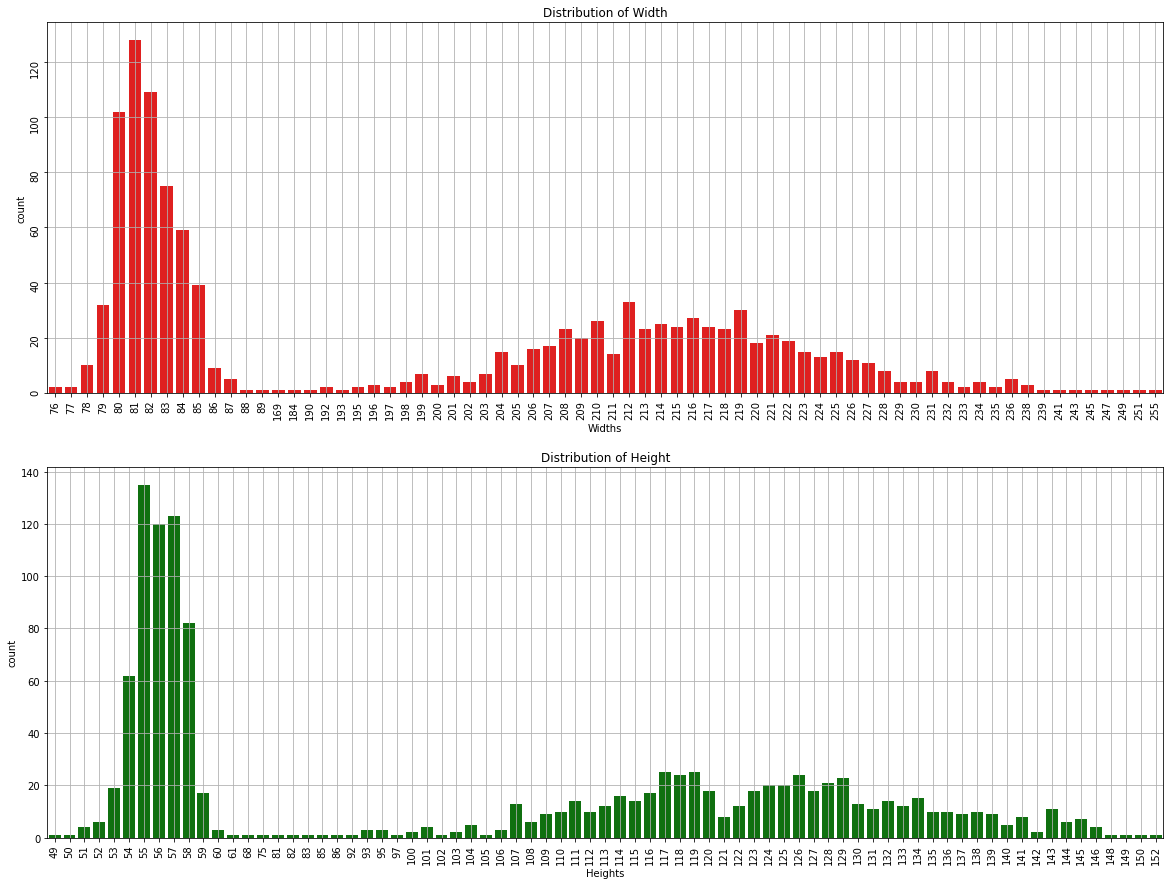

In [17]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20,15))
sns.countplot(widths, color='r', ax=axs[0])
plt.xticks(rotation = 90)
sns.countplot(heights, color='g', ax=axs[1])


axs[0].set_title('Distribution of Width')
axs[0].set_xlabel('Widths')
axs[0].grid()
axs[0].tick_params(labelrotation=90)


axs[1].set_title('Distribution of Height')
axs[1].set_xlabel('Heights')
axs[1].grid()
axs[0].tick_params(labelrotation=90)

plt.show();

# Config


In [19]:
# specify the shape of the inputs for our network
IMG_SHAPE = (100, 100, 3)

# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100

# define the path to the base output directory
BASE_OUTPUT = "/contet/output"

# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [20]:
!pwd

/content


# Euclidean distance function

In [21]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# Making pairs

In [22]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
 
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]

		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

# Data Loader

## Preprocessing Images

In [53]:
def preprocess_img(img):
    img = cv2.resize(img, (IMG_SHAPE[1], IMG_SHAPE[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img/255.
    return img

In [54]:
def load_data(img_location, name):
    imgs = []
    labels = []
    for img in os.listdir(os.path.join(img_location, name)):
        img_arr = cv2.imread(os.path.join(img_location, name, img))
        img_arr = preprocess_img(img_arr)
        labels.append(name)
        imgs.append(img_arr)
    
    return imgs, labels    

## Creating train and val imagesets

In [55]:
aayush_train_imgs, aayush_train_labels = load_data(train_data, "Aayush")
rudra_train_imgs, rudra_train_labels = load_data(train_data, "Rudra")
aayush_val_imgs, aayush_val_labels = load_data(val_data, "Aayush")
rudra_val_imgs, rudra_val_labels = load_data(val_data, "Rudra")

train_imgs = aayush_train_imgs + rudra_train_imgs
train_labels = aayush_train_labels + rudra_train_labels

val_imgs = aayush_val_imgs + rudra_val_imgs
val_labels = aayush_val_labels + rudra_val_labels

In [56]:
train_imgs = np.array(train_imgs)
val_imgs = np.array(val_imgs)

In [57]:
# train_imgs = np.expand_dims(train_imgs, axis = -1)
# val_imgs = np.expand_dims(val_imgs, axis = -1)

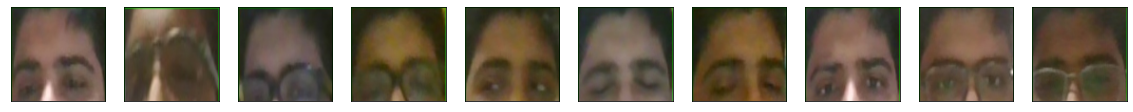

In [58]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(train_imgs[i])
    # plt.xticks(train_labels[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [59]:
# Aayush : 0, Rudra : 1
train_labels = np.array([0 if label=="Aayush" else 1 for label in train_labels], "int")
val_labels = np.array([0 if label=="Aayush" else 1 for label in val_labels], "int")

In [60]:
print(f"train_imgs shape : {train_imgs.shape}")
print(f"val_imgs shape : {val_imgs.shape}")
print(f"train_labels shape : {train_labels.shape}")
print(f"val_labels shape : {val_labels.shape}")

train_imgs shape : (779, 100, 100, 3)
val_imgs shape : (365, 100, 100, 3)
train_labels shape : (779,)
val_labels shape : (365,)


## Pair Sets

In [61]:
train_pairs, train_pair_labels = make_pairs(train_imgs, train_labels)
val_pairs, val_pair_labels = make_pairs(val_imgs, val_labels)

In [62]:
print(f"train_pairs shape : {train_pairs.shape}")
print(f"val_pairs shape : {val_pairs.shape}")
print(f"train_pair_labels shape : {train_pair_labels.shape}")
print(f"val_pair_labels shape : {val_pair_labels.shape}")

train_pairs shape : (1558, 2, 100, 100, 3)
val_pairs shape : (730, 2, 100, 100, 3)
train_pair_labels shape : (1558, 1)
val_pair_labels shape : (730, 1)


## Building montage

The images pairs will not appear if we have normalized the image data


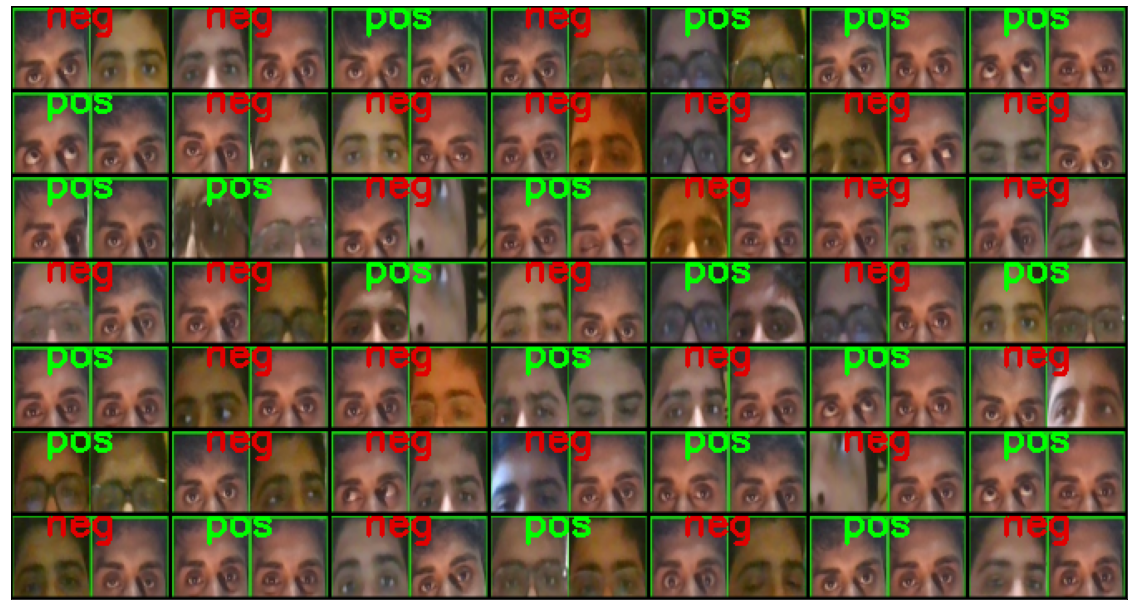

In [40]:
images = []
for i in np.random.choice(np.arange(0, len(train_pairs)), size=(49,)):
	# grab the current image pair and label
	imageA = train_pairs[i][0]
	imageB = train_pairs[i][1]
	label = train_pair_labels[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with four
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((105, 205, 3), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[2:102, 2:202, :] = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (225, 0, 0) if label[0] == 0 else (0, 255, 0)
	# create a 3-channel RGB image from the grayscale pair, resize
	# it from 60x36 to 96x51 (so we can better see it), and then
	# draw what type of pair it is on the image
	vis = cv2.merge([output])
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (20, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
	# add the pair visualization to our list of output images
	images.append(vis)
# construct the montage for the images
montage = build_montages(images, (96, 51), (7, 7))[0]
# show the output montage
plt.figure(figsize=(20, 20))
plt.xticks([])
plt.yticks([])
print("The images pairs will not appear if we have normalized the image data")
plt.imshow(montage);

# Complete architecture

## Siamese network


In [63]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim, name="Emdedding")(pooledOutput)

	# build the model
	model = Model(inputs, outputs)

	# return the model to the calling function
	return model

In [64]:
# configure the siamese network
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE, 128)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance, name="Euclidean_distance")([featsA, featsB])
outputs = Dense(1, activation="sigmoid", name="similarity")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs, name="SiameseNetwork")


# compile the model
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

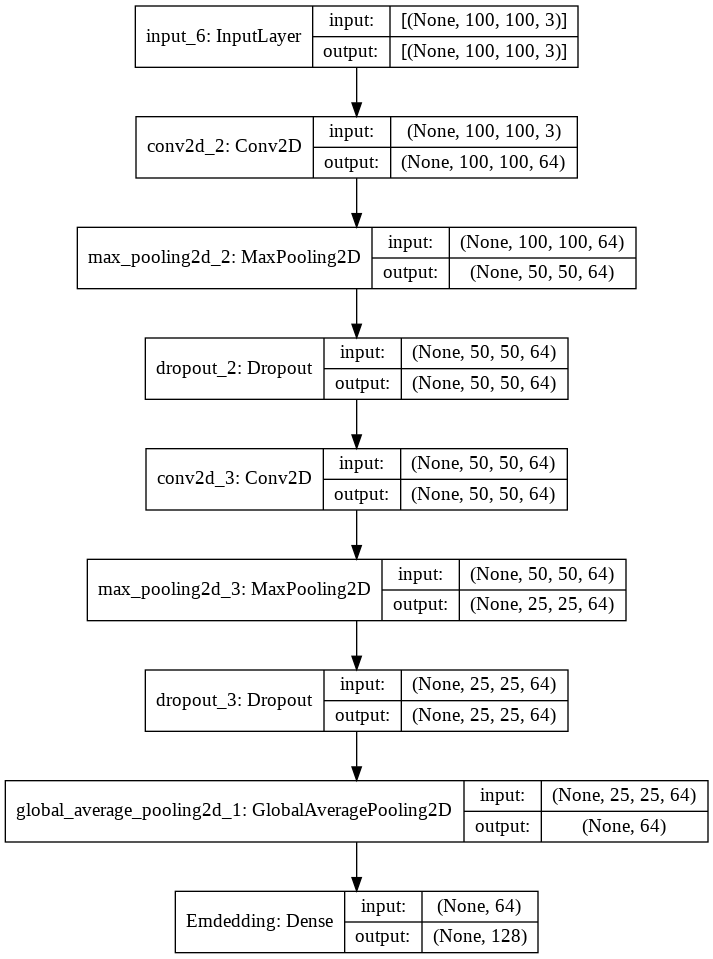

In [65]:
plot_model(featureExtractor, to_file='featureExtractor.png', show_shapes=True, show_layer_names=True)

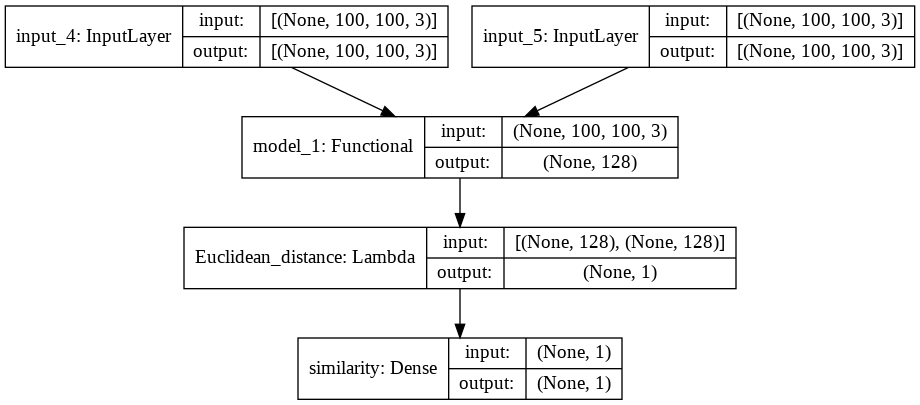

In [66]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [67]:
featureExtractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 64)        0   

In [68]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          25600       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
Euclidean_distance (Lambda)     (None, 1)            0           model_1[0][0]       

## Training

In [69]:
showTraining = PlotLossesKeras()
callbacks = [showTraining]

In [70]:
train_pairs[:, 0].shape

(1558, 100, 100, 3)

In [71]:
train_pairs[:, 1].shape

(1558, 100, 100, 3)

In [72]:
train_pair_labels[:].shape

(1558, 1)

In [73]:
x_train = np.array([train_pairs[:, 0], train_pairs[:, 1]])
y_train = train_pair_labels[:]
x_val = np.array([val_pairs[:, 0], val_pairs[:, 1]])
y_val = val_pair_labels[:]

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"y_val shape : {y_val.shape}")

x_train shape : (2, 1558, 100, 100, 3)
y_train shape : (1558, 1)
x_val shape : (2, 730, 100, 100, 3)
y_val shape : (730, 1)


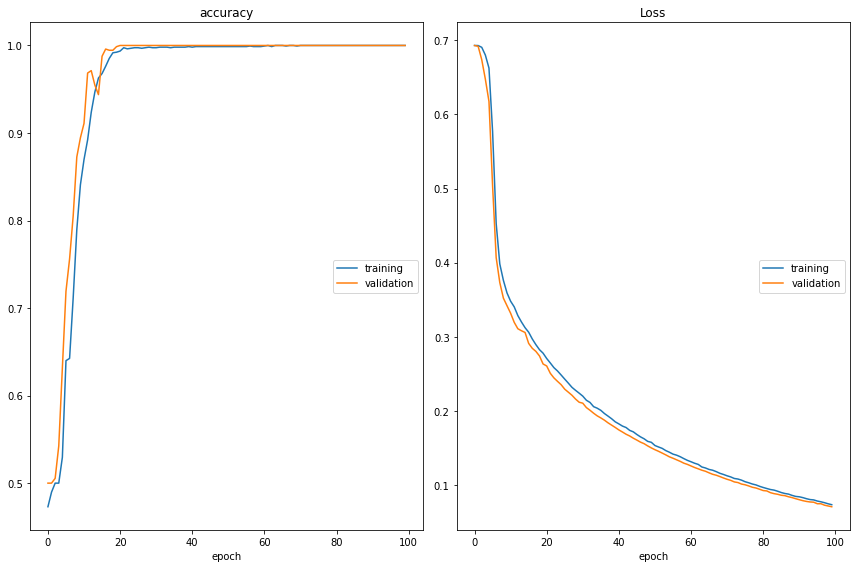

accuracy
	training         	 (min:    0.473, max:    1.000, cur:    1.000)
	validation       	 (min:    0.500, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.073, max:    0.693, cur:    0.073)
	validation       	 (min:    0.070, max:    0.693, cur:    0.070)


In [74]:
train_history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels[:],
                          validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_pair_labels[:]),
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          callbacks=[callbacks])

# Saving the model

In [75]:
model.save("/content/Siamese_Network_only_eyes")

INFO:tensorflow:Assets written to: /content/Siamese_Network_only_eyes/assets


INFO:tensorflow:Assets written to: /content/Siamese_Network_only_eyes/assets


In [76]:
!zip -r /content/Siamese_Network_only_eyes.zip /content/Siamese_Network_only_eyes

  adding: content/Siamese_Network_only_eyes/ (stored 0%)
  adding: content/Siamese_Network_only_eyes/assets/ (stored 0%)
  adding: content/Siamese_Network_only_eyes/variables/ (stored 0%)
  adding: content/Siamese_Network_only_eyes/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: content/Siamese_Network_only_eyes/variables/variables.index (deflated 64%)
  adding: content/Siamese_Network_only_eyes/saved_model.pb (deflated 89%)


In [77]:
!ls

adc.json	      model.png  Only_eyes.zip	Siamese_Network_only_eyes
featureExtractor.png  Only_eyes  sample_data	Siamese_Network_only_eyes.zip


In [78]:
from google.colab import files
files.download("Siamese_Network_only_eyes.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>